# ESE 545 Homework 1 - Joseph Lauigan

In [2]:
import numpy as np
import time
from collections import Counter
import random
import itertools
import math
import matplotlib.pyplot as plt
from itertools import chain
import csv

In [3]:
# Debug and timing analysis modes
debug = True
timing_analysis = True

## Problem 1

In [4]:
#Import and parse Netflix_data.txt into MxN matrix; M - # of movies, N - # of users

# This section imports the Netflix_data.txt file and compiles a sparse, binary matrix indicating
# if a given user(column) has rated a given movie(row) 3+ stars. Users that have rated >20 movies
# are discarded.

# row index assignments for the movies are given by index in "movie_column" variable. column index assignments for users
# are given by the dictionary "user_index" - whose entries are in the form {'user_ID',column_index}
# Final matrix is "data_matrix" 2d-numpy array

raw_data = []
data_matrix = []
movie_column = []
current_movie = -1
num_movies = 0
deleted_users = []

if debug:
    num_ratings = 0
    num_3_ratings = 0

if timing_analysis:
    start_time = time.time()

#open and import Netflix_data.txt and parse off user ratings that are less than 3 stars
with open("Netflix_data.txt") as open_data:
    for line in open_data:
        line1 = line.strip("\n")
        if ':' in line1:
            number = line1.split(':')[0]
            raw_data.append("movie "+ number)
            movie_column.append(number)
            num_movies += 1
        else:
            num_ratings += 1
            line_data = line1.split(',')
            if(int(line_data[1]) >= 3):
                num_3_ratings += 1
                raw_data.append(line_data[0])


if debug:
    print("Imported",num_3_ratings," 3 star ratings out of",num_ratings,"ratings")
    print("Imported",num_movies,"movies")

#Using Counter objects, remove users with >= 20 movies rated
user_counts = Counter(raw_data)
user_counts_ordering = Counter(raw_data)
user_nums_raw = len(user_counts) - num_movies

for key,value in list(user_counts_ordering.items()):
    if value > 19:
        deleted_users.append(key)
        del user_counts_ordering[key]
    
#construct base numpy array to be used as data_matrix
unique_users = user_nums_raw - len(deleted_users)
data_matrix = np.zeros((num_movies,unique_users))

if debug:
    print("Removed",len(deleted_users),"users out of",user_nums_raw,)
    print("The number of unique users is",unique_users)

#filter out 
user_row = list(filter(lambda x: 'movie' not in x, list(user_counts_ordering.keys()))) #filter out the movie entries in Counter key list

#assign users to column in data_matrix - hold in dictionary of form {user:index}
user_index = {}
index = 0
for user in user_row:
    user_index[user] = index
    index += 1

    

for line in raw_data:
    if 'movie' in line:
        current_movie += 1
    else:
        if user_counts[line] < 20:
            data_matrix[current_movie][user_index[line]] = 1

                
if timing_analysis:
    print("Data matrix compiled: It's been ",((time.time()-start_time)/60),"minutes")  
del raw_data

Imported 20496505  3 star ratings out of 24053764 ratings
Imported 4499 movies
Removed 241513 users out of 467134
The number of unique users is 225621
Data matrix compiled: It's been  0.96879141330719 minutes


## Problem 2 

The average jaccard distance for 10,000 pairs is: 0.9813421412371682
The lowest jaccard distance is: 0.5


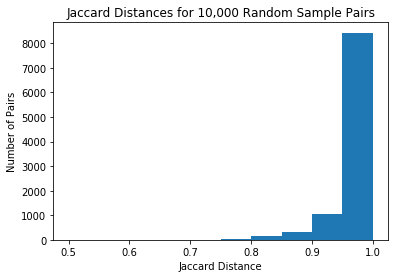

Jaccard Distance for 10,000 pairs done: It's been  0.7279930233955383 minutes


In [4]:
#create 10,000 random pairings and compute average jaccard distance between pairs and plot
rand_pairs = []
num_users = len(user_row)

if timing_analysis:
    start_time = time.time()
for i in range(0,9999):
    a = 0
    b = 0
    #ensure that a != b before appending to rand_pair list
    while(a == b):
        a = random.randint(0,num_users)
        b = random.randint(0,num_users)
        
    rand_pairs.append([a,b])


#check for pair counts, and make sure no duplicates
pair_counts = Counter(map(tuple,rand_pairs))
duplicates = [pair for pair,count in pair_counts.items() if count > 1]

if not duplicates: #no duplicate pairs
    #dictionary to hold jaccard distance b/w pairs
    jac_distance = {}
    
    #compute jaccard distance, each user column will be represented by set of movie #'s they have rated
    for pair in rand_pairs:
        #convert binary column representation of user to set of movie numbers aka row indexes of 1's
        col1 = list(data_matrix[:,pair[0]])
        col2 = list(data_matrix[:,pair[1]])
        col1_indx = [i for i, x in enumerate(col1) if x == 1]
        col2_indx = [i for i, x in enumerate(col2) if x == 1]
        pair_intersect = len(list(set(col1_indx).intersection(col2_indx)))
        pair_union = len(list(set(col1_indx).union(col2_indx)))
        jac_distance[str(pair)] = 1 - (pair_intersect/pair_union)
    
    #find minimum jaccard distance between pairs
    min_index = min(jac_distance, key=jac_distance.get)
    min_jac_distance = jac_distance[min_index]
    
    #compute average jaccard distance for all 10,000 pairs
    dist_sum = 0
    length = len(jac_distance)
    for item in jac_distance:
        dist_sum += jac_distance[item]

    avg_jac_distance = dist_sum/length
    print("The average jaccard distance for 10,000 pairs is:",avg_jac_distance)
    print("The lowest jaccard distance is:",min_jac_distance)
    
    #Plot histogram of jaccard distances
    plt.hist(list(jac_distance.values()))
    plt.title("Jaccard Distances for 10,000 Random Sample Pairs")
    plt.xlabel("Jaccard Distance")
    plt.ylabel("Number of Pairs")
    plt.show()
    
    if timing_analysis:
        print("Jaccard Distance for 10,000 pairs done: It's been ",((time.time()-start_time)/60),"minutes")

else: #fail safe so know when random pairing resulted in duplicate
    print("duplicate random pair found. Restart subroutine")

## Problem 3 

In [7]:
#number of rows needs to be prime, so check to see if number of rows is prime, if not, find nearest prime
num_movies_is_prime = True

if timing_analysis:
    start_time = time.time()
#check to see if # of rows is prime
for i in range(2,num_movies):
    if num_movies % i == 0:
        num_movies_is_prime = False
        break

#if not prime, find nearest_prime between num_movies and 2*num_movies
if(not num_movies_is_prime):
    #find nearest prime number
    nearest_prime = 0
    for i in range(num_movies,2*num_movies):
        i_prime = True
        for j in range(2,i):
            if i % j == 0:
                i_prime = False
                break
        
        if(i_prime):
            nearest_prime = i
            break
    
    r = nearest_prime
    rows_to_augment = np.zeros((r-num_movies,unique_users))
    data_matrix = np.concatenate((data_matrix,rows_to_augment),axis=0)
    print("The number of rows has been augmented to",nearest_prime)
    
    if timing_analysis:
        print("Checking if # of rows is prime and augmenting done: It's been ",((time.time()-start_time)/60),"minutes")
else:
    r = num_movies
    print("The number of rows were already prime")
    
#The more efficient way to store the data is in a signature matrix of hash functions. 
#we will use 100 hash functions for this as a means to showcase storage. so sig_matrix will be (m x unique_users)
#actual # of hash functions will be explored in later problem
m_test = 100

if debug:
    print(m_test,"hash functions have been used for signature matrix test")
    
if timing_analysis:
    start_time = time.time()

#create a,b pairings for each of the 10,000 hash functions; loop until no duplicate a,b pairings
ab_duplicates_test = 1
while(ab_duplicates_test):
    a_b_pairs_test = []
    for i in range(m_test):
        a = 0
        b = 0
    
        while(a == b):
            a = random.randint(0,r-1)
            b = random.randint(0,r-1)
    
        a_b_pairs_test.append([a,b])

    #check for pair counts, and make sure no duplicates
    ab_pair_counts = Counter(map(tuple,a_b_pairs_test))
    ab_duplicates_test = [pair for pair,count in ab_pair_counts.items() if count > 1]

if timing_analysis:
    print("Hash function parameters determined")
    print("It's been ",((time.time()-start_time)/60),"minutes")
    
#now populate the signature matrix. need to filter out non-zero indexes of each column.
if timing_analysis:
    start_time = time.time()
    

#create matrix to hold values each hash function maps each row to. rows are a_b pairs, cols are movie index
hash_values_test = np.full((len(a_b_pairs_test),num_movies),np.inf)
pair_index = 0
for pair in a_b_pairs_test:
    hash_values_test[pair_index,:] = [(pair[0]*i + pair[1])%r for i in list(range(num_movies))]
    pair_index += 1

print("hash_values matrix compiled. It's been ",((time.time()-start_time)/60),"minutes since hash function parameters determined")

if timing_analysis:
    start_time = time.time()

sig_matrix_test = np.full((m_test,unique_users),np.inf)
for i in range(unique_users):
    #find indexes where column has 1
    #iterate through all hash functions for a given user
    current_col_indx = [i for i, x in enumerate(list(data_matrix[:,i])) if x == 1]
    sig_matrix_test[:,i] = [min([hash_values_test[j][index] for index in current_col_indx]) for j in range(m_test)]
    
if timing_analysis:
    print("Signature matrix complete: It's been ",((time.time()-start_time)/60),"minutes since hash_values determined")

The number of rows has been augmented to 4507
Checking if # of rows is prime and augmenting done: It's been  0.3626653552055359 minutes
100 hash functions have been used for signature matrix test
Hash function parameters determined
It's been  6.999572118123372e-05 minutes
hash_values matrix compiled. It's been  0.003786158561706543 minutes since hash function parameters determined
Signature matrix complete: It's been  9.712041958173115 minutes since hash_values determined


## Problem 4 

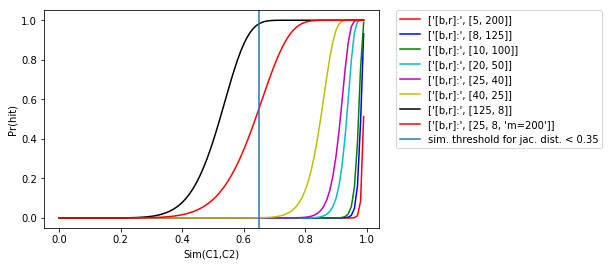

In [10]:
# need to do an analysis of figuring out the best b,r values for different m 
sim = [item/100 for item in list(range(100))]
colors = ['r','b','g','c','m','y','k','r'] 
color_index = 0

# [b,r]: (4,250), (5,200), (8,125), (10,100), (20,50),(25,40)
pairings = [[5,200],[8,125],[10,100],[20,50],[25,40],[40,25],[125,8],[25,8,'m=200']] #[250,8,'m=2000']

for items in pairings:
    pr = [1-(1-(i**items[1]))**items[0] for i in sim]
    plt.plot(sim, pr, colors[color_index], label=['[b,r]:',items])
    color_index += 1
    
plt.axvline(x=0.65, label = 'sim. threshold for jac. dist. < 0.35')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Sim(C1,C2)")
plt.ylabel("Pr(hit)")
plt.show()

for [125, 8, 'm=1000'] value at sim(C1,C2) = 0.65 is 0.9825410061200314
for [250, 8, 'm=2000'] value at sim(C1,C2) = 0.65 is 0.9996951835326993
for [100, 5, 'm=500'] value at sim(C1,C2) = 0.65 is 0.9999955964930552
for [50, 10, 'm=500'] value at sim(C1,C2) = 0.65 is 0.4922212137958185
for [20, 5, 'm=100'] value at sim(C1,C2) = 0.65 is 0.9151289183523188


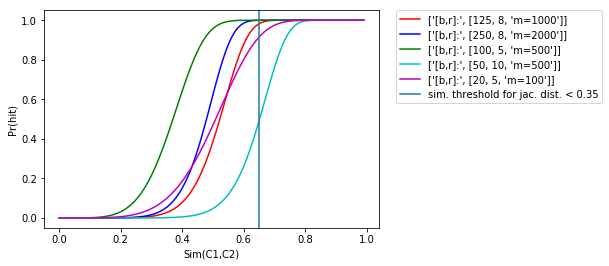

In [11]:
pair_in_depth = [[125,8,'m=1000'],[250,8,'m=2000'],[100,5,'m=500'],[50,10,'m=500'],[20,5,'m=100']]
color_index = 0

for items in pair_in_depth:
    pr = [1-(1-(i**items[1]))**items[0] for i in sim]
    plt.plot(sim, pr, colors[color_index], label=['[b,r]:',items])
    color_index += 1 
    print("for",items,"value at sim(C1,C2) = 0.65 is",pr[65])
plt.axvline(x=0.65, label = 'sim. threshold for jac. dist. < 0.35')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Sim(C1,C2)")
plt.ylabel("Pr(hit)")
plt.show()

In [9]:
#now to create the signature matrix
m = 1000 #we will use 1000 hash functions. so sig_matrix will be (m x unique_users)
bands = 125
r_val = 8

if debug:
    print(m,"hash functions have been used for signature matrix")
    
if timing_analysis:
    start_time = time.time()

#create a,b pairings for each of the 10,000 hash functions; loop until no duplicate a,b pairings
ab_duplicates = 1
while(ab_duplicates):
    a_b_pairs = []
    for i in range(m):
        a = 0
        b = 0
    
        while(a == b):
            a = random.randint(0,r-1)
            b = random.randint(0,r-1)
    
        a_b_pairs.append([a,b])

    #check for pair counts, and make sure no duplicates
    ab_pair_counts = Counter(map(tuple,a_b_pairs))
    ab_duplicates = [pair for pair,count in ab_pair_counts.items() if count > 1]

if timing_analysis:
    print("Hash function parameters determined")
    print("It's been ",((time.time()-start_time)/60),"minutes")
    
#now populate the signature matrix. need to filter out non-zero indexes of each column.

if timing_analysis:
    start_time = time.time()
    

hash_values = np.full((len(a_b_pairs),num_movies),np.inf)


#create matrix to hold values each hash function maps each row to. rows are a_b pairs, cols are movie index
pair_index = 0
for pair in a_b_pairs:
    hash_values[pair_index,:] = [(pair[0]*i + pair[1])%r for i in list(range(num_movies))]
    pair_index += 1

sig_matrix = np.full((m,unique_users),np.inf)
print('sig_matrix initialized. its been',((time.time()-start_time)/60),"minutes since hash functions determined")

#Note: Data_matrix already appended with zeros to have prime number of rows in Problem 3
for i in range(unique_users):
    #find indexes where column has 1
    current_col_indx = [i for i, x in enumerate(list(data_matrix[:,i])) if x == 1]
    
    #iterate through all hash functions for a given user
    sig_matrix[:,i] = [min([hash_values[j][index] for index in current_col_indx]) for j in range(m)]

if timing_analysis:
    print("Signature matrix complete: It's been ",((time.time()-start_time)/60),"minutes since hash functions determined")

1000 hash functions have been used for signature matrix
Hash function parameters determined
It's been  0.00011574427286783854 minutes
sig_matrix initialized. its been 0.059123798211415605 minutes since hash functions determined
Signature matrix complete: It's been  30.742717730998994 minutes since hash functions determined


In [11]:
#need to have r hash functions to hash the signature matrix bands. 
#define large prime number p to be modulus
p = 179426549

if timing_analysis:
    start_time = time.time()
#create a,b pairings for each of the r hash functions within band; loop until no duplicate a,b pairings
print('a,b pair generation started')
ab_duplicates_band = 1
while(ab_duplicates_band):
    a_b_pairs_band= []
    for i in range(r_val):
        a = 0
        b = 0
    
        while(a == b):
            a = random.randint(0,p-1)
            b = random.randint(0,p-1)

        a_b_pairs_band.append([a,b])
        
        #check for pair counts, and make sure no duplicates
        ab_pair_counts = Counter(map(tuple,a_b_pairs_band))
        ab_duplicates_band = [pair for pair,count in ab_pair_counts.items() if count > 1]

    
print('a,b pairing complete.')
print('band hashing of the sig matrix started')
candidate_pairs = []  
overall_hash_bucket = []
for i in range(bands):
    hash_bucket = {}
    
    band_sum = [np.sum(np.array([(a_b_pairs_band[k][0]*sig_matrix[i*r_val +k,j]+ a_b_pairs_band[k][1])%p for k in range(r_val)])) for j in range(unique_users)]
    hash_bucket = {}
    for j in range(unique_users):    
        if str(band_sum[j]) in hash_bucket:
            hash_bucket[str(band_sum[j])].append(j)
        else:
            hash_bucket[str(band_sum[j])] = [j]
            
    #now determine candidate pairs for this band
    candidates = [hash_bucket[key] for key in hash_bucket if len(hash_bucket[key]) > 1]
    candidate_pairs_band = [list(item) for item in [itertools.combinations(array,2) for array in candidates]]    
    candidate_pairs.append(list(chain.from_iterable(candidate_pairs_band)))

if timing_analysis:
    print("Signature matrix hashed: It's been ",((time.time()-start_time)/60),"minutes since hash functions determined")

a,b pair generation started
a,b pairing complete.
band hashing of the sig matrix started
Signature matrix hashed: It's been  20.686080535252888 minutes since hash functions determined


In [12]:
with open('similarPairs.csv','w') as writeFile:
  similarWriter = csv.writer(writeFile, delimiter=',')

  for i in range(len(candidate_pairs)):
    listPairs = list(candidate_pairs[i])
        
    for j in range(len(listPairs)):
      similarWriter.writerow([i, listPairs[j]])

## Problem 5

In [13]:
def nearest_neighbor(user_list):
    # function is passed a list of movies a user liked (movie_indexes) . May or may not have seen this user before
    # Thus the function must create a signature column for this user_list, then do a nearest neighbor search. This requires
    # banding the signature matrix again, but this time, start with determining the hash value for each band of the queried user
    # Now, when doing a searh of the signature matrix, only keep users that hash to the same bucket as the queried user.
    # After this, we will have a list of users that hashed to the same bucket in any of the bands, then do a jaccard distance
    # calculation on the signature matrix representation of these users. Any users that have a <0.35 sig_mat jacc. distance
    # are then calculated for an unhashed jaccard distance. Take the minimum distance from this set of users and return as 
    # nearest neighbor. Will return [userID,movie_list_of_user]
    
    #create signature representation of queried user. Will use hash_values matrix previously constructed for this. 
    m = 1000
    bands = 125
    r_val = 8
    p = 8831
    #check to see if the list is of strings or ints.
    if isinstance(user_list[0],int):
        user_list = [str(item) for item in user_list]
    
        
    # a movie number's index in the movie_column is it's index in the unhashed matrix (before signautre matrix. )
    # convert user_list to row_indexes
    user_list_index = [movie_column.index(item) for item in user_list]
    

    #hashed version of queried user
    sig_column = [min([hash_values[j][index] for index in user_list_index]) for j in range(m)]

    
    #Now band hash the sig_column and store in a matrix. This will be the reference value for the band hashing of the overall
    # sig_matrix to find close users.
    user_band_sum = [np.sum([(a_b_pairs_band[k][0]*sig_column[i*r_val +k]+ a_b_pairs_band[k][1])%p for k in range(r_val)]) for i in range(bands)]
    
    #Now we have reference hash for each band
    queried_candidate_users = []
    for i in range(bands):
        queried_band_sum = [np.sum([(a_b_pairs_band[k][0]*sig_matrix[i*r_val +k,j]+ a_b_pairs_band[k][1])%p for k in range(r_val)]) for j in range(unique_users)]
        
        candidate_users_band = [user for user,value in list(enumerate(queried_band_sum)) if value == user_band_sum[i]]
        if not candidate_users_band: #no matches in this band
            continue
        candidate_users_band_up = [item for item in candidate_users_band if item not in queried_candidate_users]
        queried_candidate_users.append(candidate_users_band_up)
    
    if not queried_candidate_users:
        print('no match in hashing')
        return 0
    
    #now have a list of queried user's candidate neighbors in queried_candidate_users.
    hash_sim_thresh = 0.65
    queried_candidate_users_post_hash = []
    queried_candidate_users_unrav = list(chain.from_iterable(queried_candidate_users))
    for user in queried_candidate_users_unrav:
        pair_intersect = len(list(set(sig_matrix[:,user]).intersection(sig_column)))
        pair_union = len(list(set(sig_matrix[:,user]).union(sig_column)))
        sim = pair_intersect/pair_union
        if sim >= hash_sim_thresh:
            queried_candidate_users_post_hash.append(user)
        
    if not queried_candidate_users_post_hash:
        #no hash signatures with a high enough threshold, find the maximum among the ones we have 
        final_candidates = {}
        for user in queried_candidate_users_unrav:
            col = list(data_matrix[:,user])
            col_indx = [i for i, x in enumerate(col) if x == 1]
            pair_intersect = len(list(set(col_indx).intersection(user_list_index)))
            pair_union = len(list(set(col_indx).union(user_list_index)))
            sim = pair_intersect/pair_union
            final_candidates[str(user)] = sim
    
        max_column_index = max(final_candidates, key=final_candidates.get)
        userID_neighbor = [value for column,value in list(enumerate(user_index)) if column == int(max_column_index)]
        return userID_neighbor[0] 
    else:
        #now have list of queried user's candidate neighbors whose sig_hashs >= 0.65. Do a full data_matrix compare on these and take max
        final_candidates = {}
        for user in queried_candidate_users_post_hash:
            col = list(data_matrix[:,user])
            col_indx = [i for i, x in enumerate(col) if x == 1]
            pair_intersect = len(list(set(col_indx).intersection(user_list_index)))
            pair_union = len(list(set(col_indx).union(user_list_index)))
            sim = pair_intersect/pair_union
            final_candidates[str(user)] = sim
    

        max_column_index = max(final_candidates, key=final_candidates.get)
        print('max_column_index',max_column_index)
        userID_neighbor = [value for column,value in list(enumerate(user_index)) if column == int(max_column_index)]
        return userID_neighbor[0] 
    

In [14]:
[i for i, x in enumerate(data_matrix[:,1]) if x == 1]

[0, 312, 1144, 1306, 2151, 2451, 2456, 3028, 4265]

In [15]:
#Testing Problem 5 Function - giving it an exact match to a user already in data_matrix

query_user = [1, 313, 1145, 1307, 2152, 2451, 2457, 3029, 4266] #user 1

nearest_neighbor(query_user)

max_column_index 1


'2238063'

In [194]:
user_index['2238063']

1

In [182]:
[i for i, x in enumerate(data_matrix[:,67]) if x == 1]

[0, 1172, 2171, 3937]

In [183]:
#Testing Problem 5 Function - giving it an exact match to a user already in data_matrix

query_user = [1,1173,2172,3938] #user 67

nearest_neighbor(query_user)

user list ['1', '1173', '2172', '3938']
user list index [0, 1172, 2171, 3937]
sig column first element 250.0
user 1 first element sig matrix 172.0
length of user band sum 125 one element 36421.0
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
band 32
band 33
band 34
band 35
band 36
band 37
band 38
band 39
band 40
band 41
band 42
band 43
band 44
band 45
band 46
band 47
band 48
band 49
band 50
band 51
band 52
band 53
band 54
band 55
band 56
band 57
band 58
band 59
band 60
band 61
band 62
band 63
band 64
band 65
band 66
band 67
band 68
band 69
band 70
band 71
band 72
band 73
band 74
band 75
band 76
band 77
band 78
band 79
band 80
band 81
band 82
band 83
band 84
band 85
band 86
band 87
band 88
band 89
band 90
band 91
band 92
band 93
band 94
band 95
band 96
band 97
band 98
band 99
band 100
band 1

'2380848'

In [195]:
user_index['2380848']

67

In [184]:
[i for i, x in enumerate(data_matrix[:,2009]) if x == 1]

[7, 196, 472, 1072, 1304, 2014, 2341, 3150, 3370, 3937, 3965]

In [190]:
#Testing Problem 5 Function - giving it an exact match to a user already in data_matrix

query_user = [8,197,473,1072,1305,2015,2341,3151,2271,3938,3965] #user 2009 with some slight off

nearest_neighbor(query_user)

user list ['8', '197', '473', '1072', '1305', '2015', '2341', '3151', '2271', '3938', '3965']
user list index [7, 196, 472, 1071, 1304, 2014, 2340, 3150, 2270, 3937, 3964]
sig column first element 52.0
user 1 first element sig matrix 172.0
length of user band sum 125 one element 37973.0
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
band 32
band 33
band 34
band 35
band 36
band 37
band 38
band 39
band 40
band 41
band 42
band 43
band 44
band 45
band 46
band 47
band 48
band 49
band 50
band 51
band 52
band 53
band 54
band 55
band 56
band 57
band 58
band 59
band 60
band 61
band 62
band 63
band 64
band 65
band 66
band 67
band 68
band 69
band 70
band 71
band 72
band 73
band 74
band 75
band 76
band 77
band 78
band 79
band 80
band 81
band 82
band 83
band 84
band 85
band 86
band 87
band 88
band 89
ba

'2320186'

In [192]:
user_index['2320186']

19016

In [193]:
[i for i, x in enumerate(data_matrix[:,19106]) if x == 1]

[29, 298, 1109, 1636, 1961, 2390, 2861, 3078, 3105, 3824, 3904, 4305]

In [196]:
#Testing Problem 5 Function - giving it a random user list

query_user = [1,70,66,2001,1992,4000] #user 2009 with some slight off

nearest_neighbor(query_user)

user list ['1', '70', '66', '2001', '1992', '4000']
user list index [0, 69, 65, 2000, 1991, 3999]
sig column first element 250.0
user 1 first element sig matrix 172.0
length of user band sum 125 one element 38797.0
band 0
band 1
band 2
band 3
band 4
band 5
band 6
band 7
band 8
band 9
band 10
band 11
band 12
band 13
band 14
band 15
band 16
band 17
band 18
band 19
band 20
band 21
band 22
band 23
band 24
band 25
band 26
band 27
band 28
band 29
band 30
band 31
band 32
band 33
band 34
band 35
band 36
band 37
band 38
band 39
band 40
band 41
band 42
band 43
band 44
band 45
band 46
band 47
band 48
band 49
band 50
band 51
band 52
band 53
band 54
band 55
band 56
band 57
band 58
band 59
band 60
band 61
band 62
band 63
band 64
band 65
band 66
band 67
band 68
band 69
band 70
band 71
band 72
band 73
band 74
band 75
band 76
band 77
band 78
band 79
band 80
band 81
band 82
band 83
band 84
band 85
band 86
band 87
band 88
band 89
band 90
band 91
band 92
band 93
band 94
band 95
band 96
band 97
band 98
ban

'1197569'